<a href="https://colab.research.google.com/github/sujalarora19/DomainValuationNamekart/blob/main/LargeDataModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [10]:
df_data = pd.read_csv('Dataset.csv')
df=df_data.copy()
df.drop_duplicates(subset='domain',inplace=True)
df.rename(columns={'price':'currbid'},inplace=True)
df.drop(axis=1, columns=['priority_score'], inplace=True)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785962 entries, 0 to 785961
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   domain                            785962 non-null  object 
 1   category                          785962 non-null  object 
 2   words                             785962 non-null  object 
 3   suffix                            785962 non-null  object 
 4   whois_registrar                   785962 non-null  object 
 5   extensions_taken                  785962 non-null  int64  
 6   search_ad_competition_broad_term  785962 non-null  int64  
 7   search_ad_competition_exact_term  785962 non-null  int64  
 8   search_cpc_broad_term             785962 non-null  float64
 9   search_cpc_exact_term             785962 non-null  float64
 10  search_results_sld                785962 non-null  int64  
 11  search_results_term               785962 non-null  i

All are non-null \
No imputer needed

In [12]:
index_cols = ['domain',"currbid"]
df["log_currbid"] = np.log1p(df["currbid"])  # log(1 + x) avoids log(0)
target_col = 'log_currbid'

In [13]:

categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in index_cols]
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove(target_col)
for i in index_cols:
  if i in numerical_cols:
    numerical_cols.remove(i)

# df[categorical_cols] = df[categorical_cols].fillna('<unk>')

In [14]:
X = df[numerical_cols + categorical_cols]

y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])


# num_imputer = SimpleImputer(strategy='mean')
# X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
# X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])


scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [30]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'reg_lambda': 1, 'reg_alpha': 0.1,
    'eval_metric': ['rmse','mae'],
    'reg_lambda': 1, 'reg_alpha': 0.1,'gamma': 0

}
# {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators'¿: 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}




evals_result = {}
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=False
)

train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']

train_mae = evals_result['train']['mae']
test_mae = evals_result['test']['mae']

# print(f"Final Train RMSE: {train_rmse[-1]}")
# print(f"Final Validation RMSE: {test_rmse[-1]}")
# print(f"Final Train MAE: {train_mae[-1]}")
# print(f"Final Validation MAE: {test_mae[-1]}")


## Since I am using the log method to avoid any -ve prediction, I need to calculate the mae rmse manually


--- Final Evaluation in Original Scale (exp(log_preds)) ---
Real RMSE: 244.04
Real MAE: 24.24


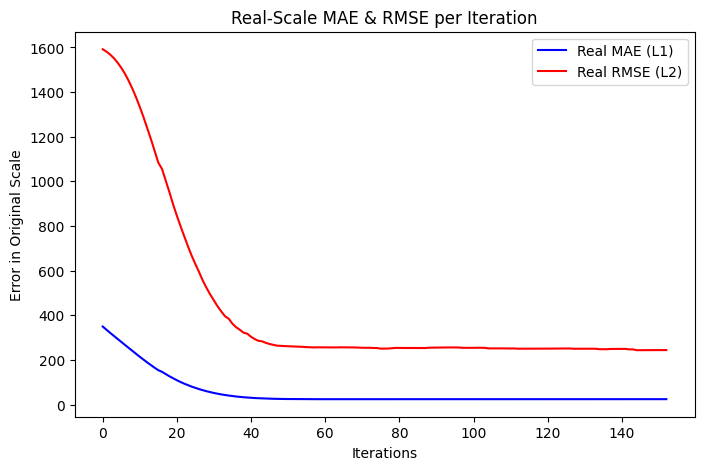

In [31]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test set (log scale)
log_preds = xgb_model.predict(dtest)

# Convert predictions and true labels back to original scale
preds_actual = np.expm1(log_preds)
true_actual = np.expm1(y_test.values)  # since you log1p'd y, reverse it too

# Compute real-world metrics
real_rmse = np.sqrt(mean_squared_error(true_actual, preds_actual))
real_mae = mean_absolute_error(true_actual, preds_actual)

print("\n--- Final Evaluation in Original Scale (exp(log_preds)) ---")
print(f"Real RMSE: {real_rmse:.2f}")
print(f"Real MAE: {real_mae:.2f}")

real_rmse_per_round = []
real_mae_per_round = []

for i in range(1, len(train_rmse) + 1):
    preds_log = xgb_model.predict(dtest, iteration_range=(0, i))
    preds_actual = np.expm1(preds_log)
    true_actual = np.expm1(y_test.values)

    rmse = np.sqrt(mean_squared_error(true_actual, preds_actual))
    mae = mean_absolute_error(true_actual, preds_actual)

    real_rmse_per_round.append(rmse)
    real_mae_per_round.append(mae)
plt.figure(figsize=(8, 5))
plt.plot(real_mae_per_round, label="Real MAE (L1)", color='blue')
plt.plot(real_rmse_per_round, label="Real RMSE (L2)", color='red')
plt.xlabel("Iterations")
plt.ylabel("Error in Original Scale")
plt.title("Real-Scale MAE & RMSE per Iteration")
plt.legend()
plt.show()


## GridCV

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Optional: RMSE scorer (if you prefer RMSE over default R²)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))  # real scale

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],      # L1 regularization
    'reg_lambda': [1, 1.5, 2]      # L2 regularization
}


xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # Much faster on large datasets
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=50,  # sample 50 random combos instead of full grid
    cv=3,
    scoring=rmse_scorer,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)


# # Use 3-fold CV; change to 5 if time/memory allows
# grid_search = GridSearchCV(
#     estimator=xgb_reg,
#     param_grid=param_grid,
#     cv=3,
#     scoring=rmse_scorer,  # Use RMSE on original scale
#     verbose=2,
#     n_jobs=-1
# )

# # Run grid search
# grid_search.fit(X_train, y_train)

# Best params
print("\nBest Parameters:")
print(grid_search.best_params_)

# Predict and evaluate
log_preds = grid_search.predict(X_test)
preds_actual = np.expm1(log_preds)
true_actual = np.expm1(y_test)

real_rmse = np.sqrt(mean_squared_error(true_actual, preds_actual))
# real_mae = mean_absolute_error(true_actual, preds_actual)

print("\n--- Final Evaluation with Best Model ---")
print(f"Real RMSE: {real_rmse:.2f}")
print(f"Real MAE: {real_mae:.2f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters:
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


NameError: name 'mean_absolute_error' is not defined